In [1]:
import numpy as np
import pandas as pd
import dask
from dask.distributed import Queue
import dask.dataframe as dd
from os.path import isfile
import sys

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# import geopandas as gp
# import pyproj 
# pyproj.datadir.set_data_dir('/storage/home/d/dcl5300/work/ENVS/cropswitching/share/proj')

dask.config.set({'array.slicing.split_large_chunks': False})

plt.rcParams['font.size'] = 18

## Dask (cluster)

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=5, resource_spec='pmem=40GB', memory='40GB', walltime='00:50:00')

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -A kaf26_c_g_sc_default
#PBS -l pmem=40GB
#PBS -l walltime=00:50:00
#PBS -e /gpfs/scratch/dcl5300/
#PBS -o /gpfs/scratch/dcl5300/

/storage/work/dcl5300/ENVS/cropswitching/bin/python -m distributed.cli.dask_worker tcp://10.102.201.234:37602 --nthreads 5 --memory-limit 37.25GiB --name dummy-name --nanny --death-timeout 60 --local-directory /gpfs/scratch/dcl5300 --protocol tcp://



In [4]:
cluster.scale(jobs=30)  # ask for jobs

In [5]:
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.234:37602,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Price projections

## Cumulative uncertainty analysis

### Calculations

In [28]:
df = pd.read_csv('../data/future/yields/barley/barley_17019_RCP45_30-50_SM_ave_NOTREND.csv')

In [30]:
len(df[::2]['param'].unique())

500

In [12]:
df = pd.read_csv('../data/future/prices/barley_30-50_BVAR.csv')

In [26]:
len(df[::100]['param'].unique())

540

In [7]:
########################################################################
##### Cumulative uncertainty analysis of Kim et al (2019)
## https://doi.org/10.1016/j.hydroa.2019.100024
## NOTE this requires increasing RAM to persist the dask dataframe
## ==> ~150 GB for yield_step = 10, price_step = 100
########################################################################
def cuml_uncertainty_analysis_DASK(yield_models, df_price, yield_step, price_step):
    # Restart client
    client.restart()
    
    # Read yields
    n_yield = len(yield_models)
    dfs_yield = []
    for model in yield_models:
        df = pd.read_csv('../data/future/yields/' + model)
        df = df[::yield_step]
        dfs_yield.append(df)

    # Edit indices so no overlap
    dfs_yield_new = []
    for i in range(n_yield):
        df = dfs_yield[i]
        df['param'] = (df['param'] * n_yield) + i
        dfs_yield_new.append(df)

    del dfs_yield
    # Dask dataframe
    df_yield = pd.concat(dfs_yield_new)
    df_yield = dd.from_pandas(df_yield, npartitions=1000)
    
    # Read prices
    df_price = pd.read_csv('../data/future/prices/' + df_price)
    df_price = df_price[::price_step]
    df_price = dd.from_pandas(df_price, npartitions=1)
    
    # Merge
    df = dd.merge(df_yield, df_price, on ='year', suffixes = ('_yield', '_price'))
    
    # Calculate income
    df['log_income'] = df['log_yield_sim'] + df['log_price_TREND']
    df['income'] = np.exp(df['log_income'])
    
    # Outcome metric = average profit
    df = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].mean().reset_index()
    
    df = client.persist(df) # faster
    
    # Uncertainty metric = SD
    clim_SD = df.groupby(['param_yield', 'param_price'])['income'].std().mean().compute() # climate uncertainty
    clim_yield_SD = df.groupby(['param_price'])['income'].std().mean().compute() # climate + yield
    clim_yield_price_SD = df['income'].std().compute() # climate + yield + price uncertainty
    
    # Uncertainty metric = range
    clim_R = (df.groupby(['param_yield', 'param_price'])['income'].max() - df.groupby(['param_yield', 'param_price'])['income'].min()).mean().compute() # climate uncertainty
    clim_yield_R = (df.groupby(['param_yield'])['income'].max() - df.groupby(['param_yield'])['income'].min()).mean().compute() # climate + yield
    clim_yield_price_R = (df['income'].max() - df['income'].min()).compute() # climate + yield + price uncertainty
    
    # Out dataframe
    out = pd.DataFrame(data = {'climate' : [clim_SD, clim_R],
                              'cimate + yield' : [clim_yield_SD, clim_yield_R],
                              'climate + yield + price' : [clim_yield_price_SD, clim_yield_price_R]},
                      index = ['SD','range'])
    
    return out

# def cuml_uncertainty_analysis(yield_models, df_price, step):
#     # Read yields
#     n_yield = len(yield_models)
#     dfs_yield = []
#     for model in yield_models:
#         df = pd.read_csv('../data/future/yields/' + model)
#         df = df[::step]
#         dfs_yield.append(df)

#     # Edit indices so no overlap
#     dfs_yield_new = []
#     for i in range(n_yield):
#         df = dfs_yield[i]
#         df['param'] = (df['param'] * n_yield) + i
#         dfs_yield_new.append(df)

#     del dfs_yield
#     df_yield = pd.concat(dfs_yield_new)
    
#     # Read prices
#     df_price = pd.read_csv('../data/future/prices/' + df_price)
#     df_price = df_price[::step]
    
#     # Merge
#     df = pd.merge(df_yield, df_price, on ='year', suffixes = ('_yield', '_price'))
    
#     # Calculate income
#     df['log_income'] = df['log_yield_sim'] + df['log_price_TREND']
#     df['income'] = np.exp(df['log_income'])
    
#     # Outcome metric = average profit
#     df = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].mean().reset_index()

#     # Uncertainty metric = SD
#     clim_SD = df.groupby(['param_yield', 'param_price'])['income'].std().mean() # climate uncertainty
#     clim_yield_SD = df.groupby(['param_price'])['income'].std().mean() # climate + yield
#     clim_yield_price_SD = df['income'].std() # climate + yield + price uncertainty
    
#     # Uncertainty metric = range
#     clim_R = (df.groupby(['param_yield', 'param_price'])['income'].max() - df.groupby(['param_yield', 'param_price'])['income'].min()).mean() # climate uncertainty
#     clim_yield_R = (df.groupby(['param_yield'])['income'].max() - df.groupby(['param_yield'])['income'].min()).mean() # climate + yield
#     clim_yield_price_R = (df['income'].max() - df['income'].min()) # climate + yield + price uncertainty
    
#     # Out dataframe
#     out = pd.DataFrame(data = {'climate' : [clim_SD, clim_R],
#                               'cimate + yield' : [clim_yield_SD, clim_yield_R],
#                               'climate + yield + price' : [clim_yield_price_SD, clim_yield_price_R]},
#                       index = ['SD','range'])
    
#     return out

In [8]:
%%time
#######
# 38071
#######

ys=2
ps=100

## yield step = 10: ~1000 paramater sets for each year for each model (~3000 total)
## price step = 100: ~500 paramater sets for each year
## ==> 1.5 million income sets for each year
res_barley = cuml_uncertainty_analysis_DASK(
    yield_models = ['barley/barley_38071_RCP45_30-50_SM_week_NOTREND.csv', 'barley/barley_38071_RCP45_30-50_SR_09_NOTREND.csv', 'barley/barley_38071_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='barley_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_maize = cuml_uncertainty_analysis_DASK(
    yield_models = ['maize/maize_38071_RCP45_30-50_SM_week_NOTREND.csv', 'maize/maize_38071_RCP45_30-50_SR_09_NOTREND.csv', 'maize/maize_38071_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='maize_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_soy = cuml_uncertainty_analysis_DASK(
    yield_models = ['soy/soy_38071_RCP45_30-50_SM_week_NOTREND.csv', 'soy/soy_38071_RCP45_30-50_SR_09_NOTREND.csv', 'soy/soy_38071_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='soy_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_sorghum = cuml_uncertainty_analysis_DASK(
    yield_models = ['sorghum/sorghum_38071_RCP45_30-50_SM_week_NOTREND.csv', 'sorghum/sorghum_38071_RCP45_30-50_SR_09_NOTREND.csv', 'sorghum/sorghum_38071_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='sorghum_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_springwheat = cuml_uncertainty_analysis_DASK(
    yield_models = ['springwheat/springwheat_38071_RCP45_30-50_SM_week_NOTREND.csv', 'springwheat/springwheat_38071_RCP45_30-50_SR_09_NOTREND.csv', 'springwheat/springwheat_38071_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='wheat_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_cotton = cuml_uncertainty_analysis_DASK(
    yield_models = ['cotton/cotton_38071_RCP45_30-50_SM_week_NOTREND.csv', 'cotton/cotton_38071_RCP45_30-50_SR_09_NOTREND.csv', 'cotton/cotton_38071_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='cotton_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

# Store all for local use
res_maize['crop'] = 'maize'
res_soy['crop'] = 'soy'
res_barley['crop'] = 'barley'
res_springwheat['crop'] = 'springwheat'
res_cotton['crop'] = 'cotton'
res_sorghum['crop'] = 'sorghum'

res_all = pd.concat([res_maize, res_soy, res_barley, res_springwheat, res_cotton, res_sorghum])
res_all.index.names = ['metric']
res_all.to_csv('../data/results/38071_NT_cuml_uncer_sd_range_' + str(ys) + '_' + str(ps) + '.csv')

CPU times: user 4min 39s, sys: 20.9 s, total: 5min
Wall time: 23min 16s


In [8]:
%%time
#######
# 17019
#######

ys=2
ps=100

## yield step = 10: ~1000 paramater sets for each year for each model (~3000 total)
## price step = 100: ~500 paramater sets for each year
## ==> 1.5 million income sets for each year
res_barley = cuml_uncertainty_analysis_DASK(
    yield_models = ['barley/barley_17019_RCP45_30-50_SM_week_NOTREND.csv', 'barley/barley_17019_RCP45_30-50_SR_09_NOTREND.csv', 'barley/barley_17019_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='barley_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_maize = cuml_uncertainty_analysis_DASK(
    yield_models = ['maize/maize_17019_RCP45_30-50_SM_week_NOTREND.csv', 'maize/maize_17019_RCP45_30-50_SR_09_NOTREND.csv', 'maize/maize_17019_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='maize_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_soy = cuml_uncertainty_analysis_DASK(
    yield_models = ['soy/soy_17019_RCP45_30-50_SM_week_NOTREND.csv', 'soy/soy_17019_RCP45_30-50_SR_09_NOTREND.csv', 'soy/soy_17019_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='soy_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_sorghum = cuml_uncertainty_analysis_DASK(
    yield_models = ['sorghum/sorghum_17019_RCP45_30-50_SM_week_NOTREND.csv', 'sorghum/sorghum_17019_RCP45_30-50_SR_09_NOTREND.csv', 'sorghum/sorghum_17019_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='sorghum_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_springwheat = cuml_uncertainty_analysis_DASK(
    yield_models = ['springwheat/springwheat_17019_RCP45_30-50_SM_week_NOTREND.csv', 'springwheat/springwheat_17019_RCP45_30-50_SR_09_NOTREND.csv', 'springwheat/springwheat_17019_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='wheat_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_cotton = cuml_uncertainty_analysis_DASK(
    yield_models = ['cotton/cotton_17019_RCP45_30-50_SM_week_NOTREND.csv', 'cotton/cotton_17019_RCP45_30-50_SR_09_NOTREND.csv', 'cotton/cotton_17019_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='cotton_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

# Store all for local use
res_maize['crop'] = 'maize'
res_soy['crop'] = 'soy'
res_barley['crop'] = 'barley'
res_springwheat['crop'] = 'springwheat'
res_cotton['crop'] = 'cotton'
res_sorghum['crop'] = 'sorghum'

res_all = pd.concat([res_maize, res_soy, res_barley, res_springwheat, res_cotton, res_sorghum])
res_all.index.names = ['metric']
res_all.to_csv('../data/results/17019_NT_cuml_uncer_sd_range_' + str(ys) + '_' + str(ps) + '.csv')

CPU times: user 4min 5s, sys: 19 s, total: 4min 24s
Wall time: 22min 6s


In [9]:
%%time
#######
# 40039
#######

ys=2
ps=100

## yield step = 10: ~1000 paramater sets for each year for each model (~3000 total)
## price step = 100: ~500 paramater sets for each year
## ==> 1.5 million income sets for each year
res_barley = cuml_uncertainty_analysis_DASK(
    yield_models = ['barley/barley_40039_RCP45_30-50_SM_week_NOTREND.csv', 'barley/barley_40039_RCP45_30-50_SR_09_NOTREND.csv', 'barley/barley_40039_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='barley_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_maize = cuml_uncertainty_analysis_DASK(
    yield_models = ['maize/maize_40039_RCP45_30-50_SM_week_NOTREND.csv', 'maize/maize_40039_RCP45_30-50_SR_09_NOTREND.csv', 'maize/maize_40039_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='maize_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_soy = cuml_uncertainty_analysis_DASK(
    yield_models = ['soy/soy_40039_RCP45_30-50_SM_week_NOTREND.csv', 'soy/soy_40039_RCP45_30-50_SR_09_NOTREND.csv', 'soy/soy_40039_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='soy_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_sorghum = cuml_uncertainty_analysis_DASK(
    yield_models = ['sorghum/sorghum_40039_RCP45_30-50_SM_week_NOTREND.csv', 'sorghum/sorghum_40039_RCP45_30-50_SR_09_NOTREND.csv', 'sorghum/sorghum_40039_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='sorghum_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_springwheat = cuml_uncertainty_analysis_DASK(
    yield_models = ['springwheat/springwheat_40039_RCP45_30-50_SM_week_NOTREND.csv', 'springwheat/springwheat_40039_RCP45_30-50_SR_09_NOTREND.csv', 'springwheat/springwheat_40039_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='wheat_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

res_cotton = cuml_uncertainty_analysis_DASK(
    yield_models = ['cotton/cotton_40039_RCP45_30-50_SM_week_NOTREND.csv', 'cotton/cotton_40039_RCP45_30-50_SR_09_NOTREND.csv', 'cotton/cotton_40039_RCP45_30-50_SM_ave_NOTREND.csv'],
    df_price ='cotton_30-50_BVAR.csv', 
    yield_step = ys,
    price_step = ps
)

# Store all for local use
res_maize['crop'] = 'maize'
res_soy['crop'] = 'soy'
res_barley['crop'] = 'barley'
res_springwheat['crop'] = 'springwheat'
res_cotton['crop'] = 'cotton'
res_sorghum['crop'] = 'sorghum'

res_all = pd.concat([res_maize, res_soy, res_barley, res_springwheat, res_cotton, res_sorghum])
res_all.index.names = ['metric']
res_all.to_csv('../data/results/40039_NT_cuml_uncer_sd_range_' + str(ys) + '_' + str(ps) + '.csv')

CPU times: user 2min 58s, sys: 16.2 s, total: 3min 14s
Wall time: 16min 23s


### Plots

In [2]:
# Plotting functions
def plot_single_cuml_uncert(data, ax, title):
    # Climate
    p1 = plt.Rectangle((-data[0]/2., 0), data[0], 3, alpha=0.5)
    ax.add_patch(p1)
    ax.text(x=0, y=2.5, s='Climate', ha='center', va='center')
    
    # Climate + Yield
    p1 = plt.Rectangle((-data[1]/2., 0), data[1], 2, alpha=0.5, color='C1')
    ax.add_patch(p1)
    ax.text(x=0, y=1.5, s='Climate + Yield', ha='center', va='center')
    
    # Climate + Yield + Price
    p1 = plt.Rectangle((-data[2]/2., 0), data[2], 1, alpha=0.5, color='C2')
    ax.add_patch(p1)
    ax.text(x=0, y=0.5, s='Climate + Yield + Price', ha='center', va='center')
        
    # Add underline
    ax.arrow(x=0., y=0., dx=-0.55*data[2], dy=0., lw=2, color='black', length_includes_head=True, head_width=0.25, head_length=data[2]/50)
    ax.arrow(x=0., y=0., dx=0.55*data[2], dy=0., lw=2, color='black', length_includes_head=True, head_width=0.25, head_length=data[2]/50)
    
    # Add text
    cuml_pct = data / data[2] * 100
    ax.text(x=0.55*data[2], y=3, s='Cumulative\n Uncertainty', ha='center', va='bottom', transform=ax.transData)
    ax.text(x=0.52*data[2], y=2.5, s='{:.0f}%'.format(cuml_pct[0]), ha='left', va='center', transform=ax.transData)
    ax.text(x=0.52*data[2], y=1.5, s='{:.0f}%'.format(cuml_pct[1]), ha='left', va='center', transform=ax.transData)
    ax.text(x=0.52*data[2], y=0.5, s='{:.0f}%'.format(cuml_pct[2]), ha='left', va='center', transform=ax.transData)
    
    stage_pct = np.diff(data) / data[2] * 100
    ax.text(x=-0.55*data[2], y=3, s='Stage\n Uncertainty', ha='center', va='bottom', transform=ax.transData)
    ax.text(x=-0.52*data[2], y=2.5, s='{:.0f}%'.format(cuml_pct[0]), ha='right', va='center', transform=ax.transData)
    ax.text(x=-0.52*data[2], y=1.5, s='{:.0f}%'.format(stage_pct[0]), ha='right', va='center', transform=ax.transData)
    ax.text(x=-0.52*data[2], y=0.5, s='{:.0f}%'.format(stage_pct[1]), ha='right', va='center', transform=ax.transData)
    
    # Plot settings
    ax.set_title(title, pad=20)
    ax.set_ylim([-0.25,3])
    ax.axis('off')
    
def plot_cuml_uncert(res, title, out):
    fig, axs = plt.subplots(2,1, figsize = (8,7))

    # SD
    ax=axs[0]
    data = res.loc['SD'].to_numpy()
    plot_single_cuml_uncert(data, ax, title + ' (std. dev.)')
    
    # Range
    ax=axs[1]
    data = res.loc['range'].to_numpy()
    plot_single_cuml_uncert(data, ax, title + ' (range)')
    
    # Plot settings
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('../figs/' + out)

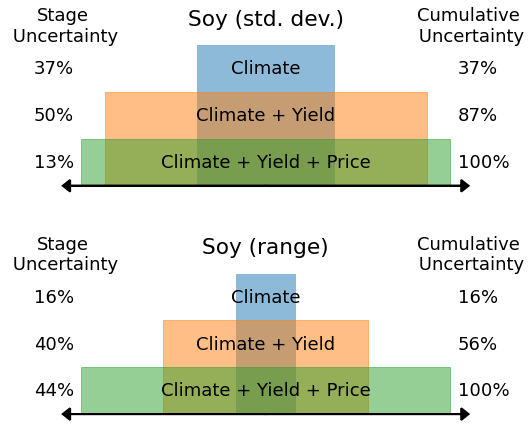

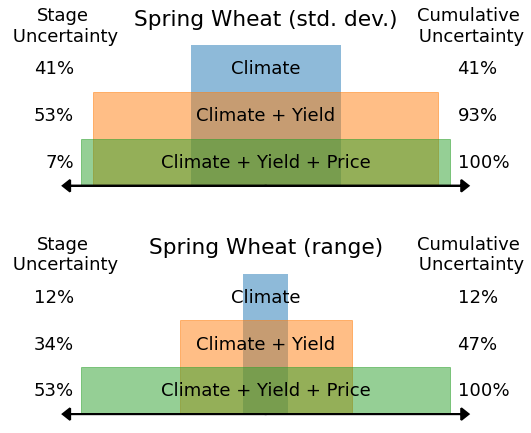

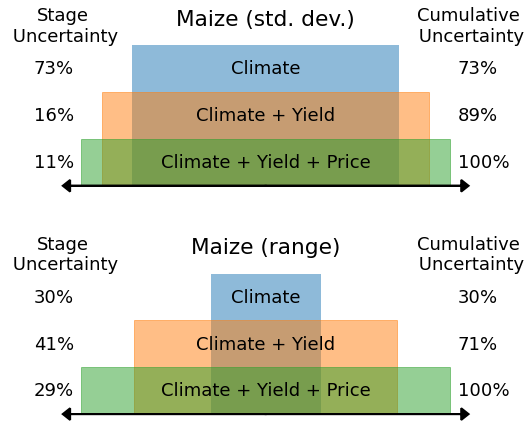

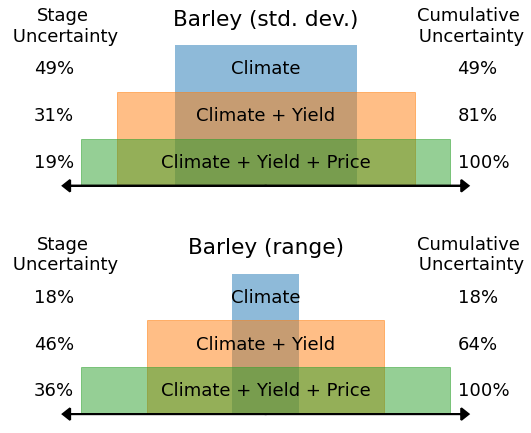

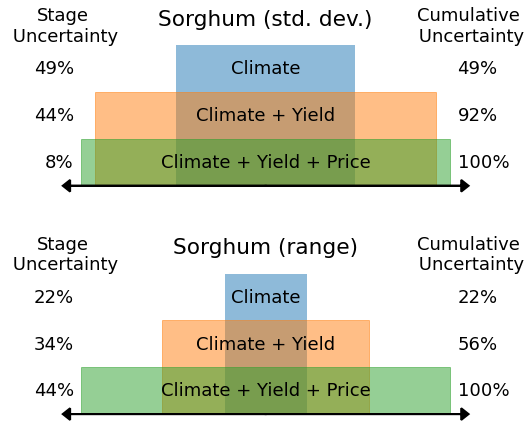

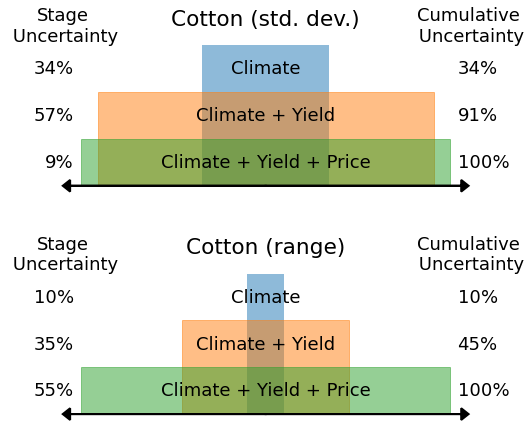

In [4]:
# Read all
res_all = pd.read_csv('../data/results/17019_NT_cuml_uncer_sd_range_2_100.csv')
res_all.set_index(['crop', 'metric'], inplace=True)

plot_cuml_uncert(res_all.loc['soy'], 'Soy', '17019_soy_UQ.pdf')
plot_cuml_uncert(res_all.loc['springwheat'], 'Spring Wheat', '17019_springwheat_UQ.pdf')
plot_cuml_uncert(res_all.loc['maize'], 'Maize', '17019_maize_UQ.pdf')
plot_cuml_uncert(res_all.loc['barley'], 'Barley', '17019_barley_UQ.pdf')
plot_cuml_uncert(res_all.loc['sorghum'], 'Sorghum', '17019_sorghum_UQ.pdf')
plot_cuml_uncert(res_all.loc['cotton'], 'Cotton', '17019_cotton_UQ.pdf')

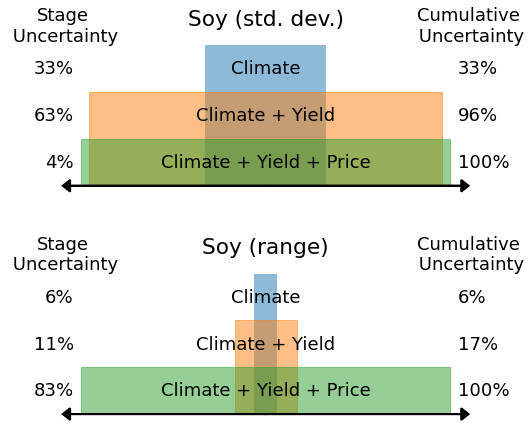

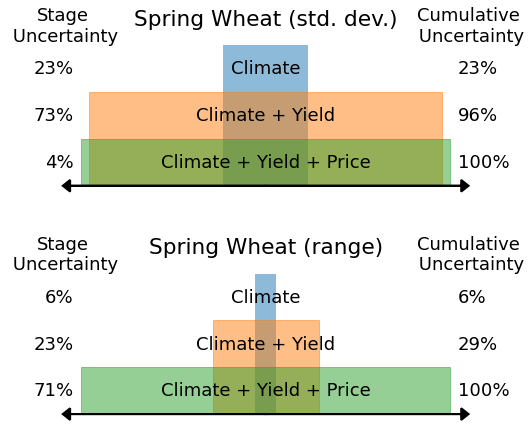

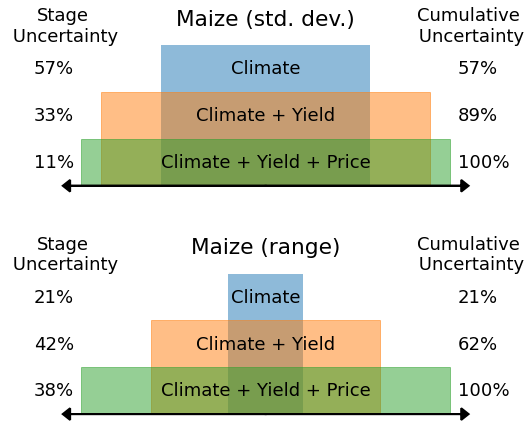

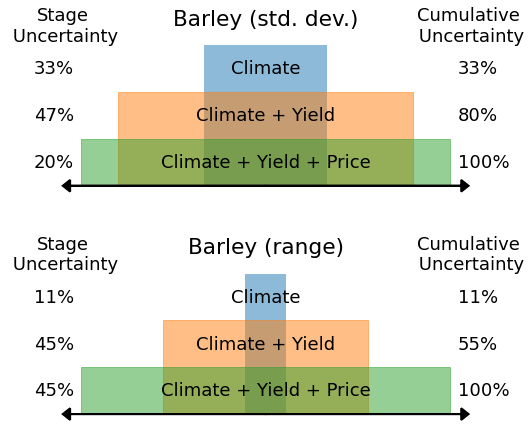

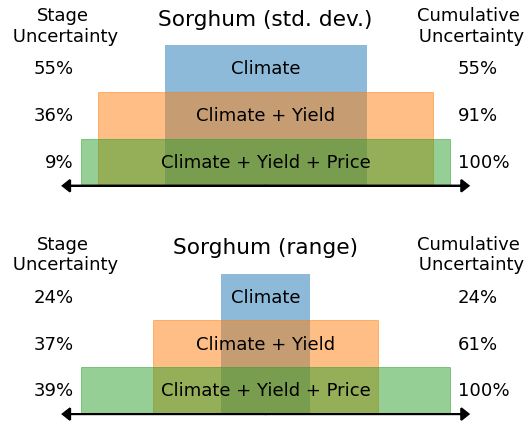

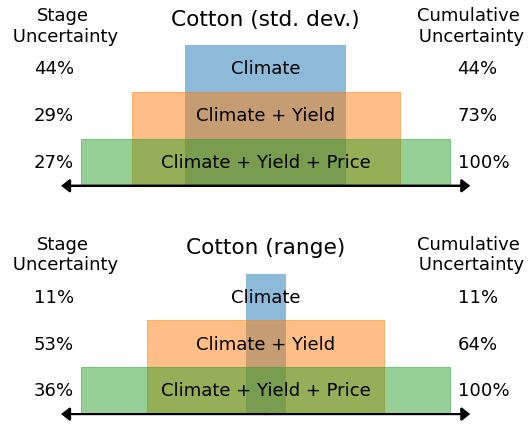

In [5]:
# Read all
res_all = pd.read_csv('../data/results/40039_NT_cuml_uncer_sd_range_2_100.csv')
res_all.set_index(['crop', 'metric'], inplace=True)

plot_cuml_uncert(res_all.loc['soy'], 'Soy', '40039_soy_UQ.pdf')
plot_cuml_uncert(res_all.loc['springwheat'], 'Spring Wheat', '40039_springwheat_UQ.pdf')
plot_cuml_uncert(res_all.loc['maize'], 'Maize', '40039_maize_UQ.pdf')
plot_cuml_uncert(res_all.loc['barley'], 'Barley', '40039_barley_UQ.pdf')
plot_cuml_uncert(res_all.loc['sorghum'], 'Sorghum', '40039_sorghum_UQ.pdf')
plot_cuml_uncert(res_all.loc['cotton'], 'Cotton', '40039_cotton_UQ.pdf')

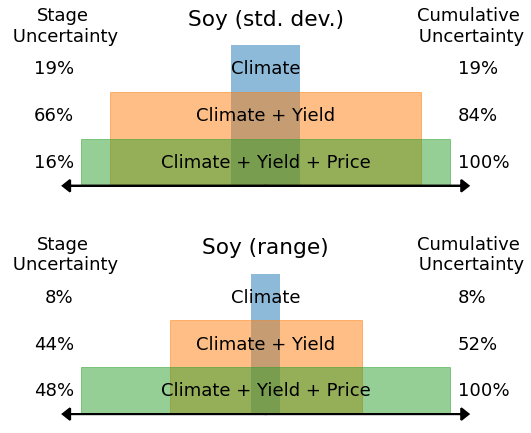

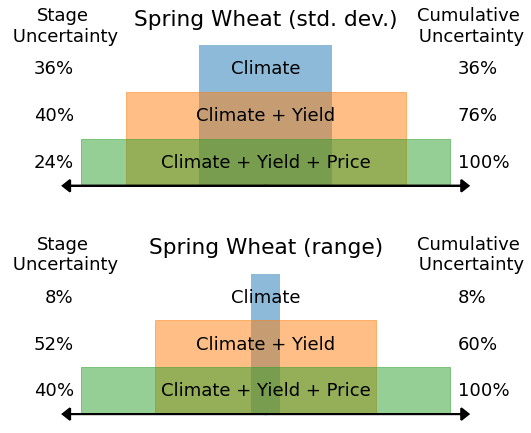

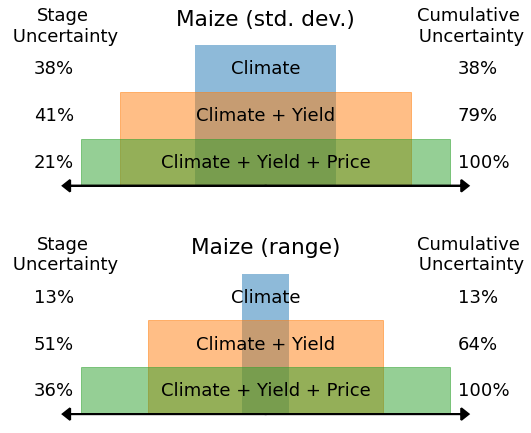

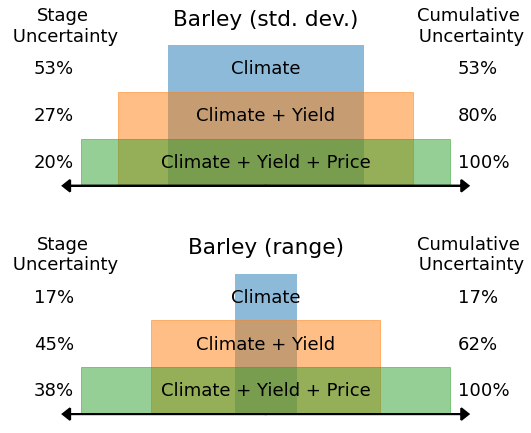

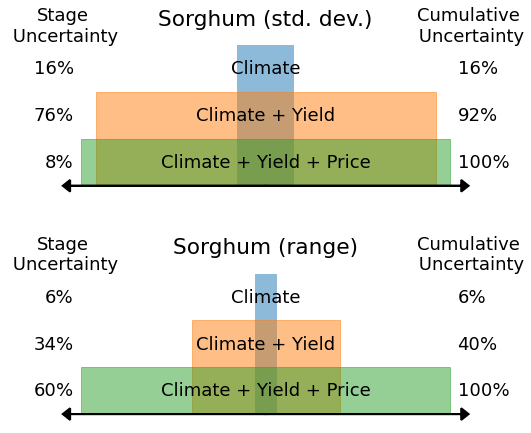

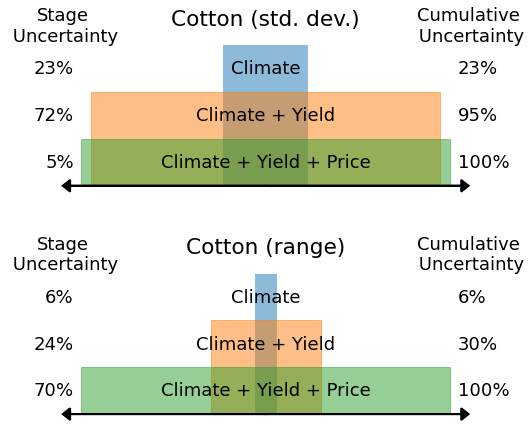

In [6]:
# Read all
res_all = pd.read_csv('../data/results/38071_NT_cuml_uncer_sd_range_2_100.csv')
res_all.set_index(['crop', 'metric'], inplace=True)

plot_cuml_uncert(res_all.loc['soy'], 'Soy', '38071_soy_UQ.pdf')
plot_cuml_uncert(res_all.loc['springwheat'], 'Spring Wheat', '38071_springwheat_UQ.pdf')
plot_cuml_uncert(res_all.loc['maize'], 'Maize', '38071_maize_UQ.pdf')
plot_cuml_uncert(res_all.loc['barley'], 'Barley', '38071_barley_UQ.pdf')
plot_cuml_uncert(res_all.loc['sorghum'], 'Sorghum', '38071_sorghum_UQ.pdf')
plot_cuml_uncert(res_all.loc['cotton'], 'Cotton', '38071_cotton_UQ.pdf')

## MORDM

### Calculations

In [15]:
def calculate_quantiles_DASK(yield_models, df_price, yield_step, price_step):
    # Restart client
    client.restart()
    
    # Read yields
    n_yield = len(yield_models)
    dfs_yield = []
    for model in yield_models:
        df = pd.read_csv('../data/future/yields/' + model)
        df = df[::yield_step]
        dfs_yield.append(df)

    # Edit indices so no overlap
    dfs_yield_new = []
    for i in range(n_yield):
        df = dfs_yield[i]
        df['param'] = (df['param'] * n_yield) + i
        dfs_yield_new.append(df)

    del dfs_yield
    # Dask dataframe
    df_yield = pd.concat(dfs_yield_new)
    df_yield = dd.from_pandas(df_yield, npartitions=1000)
    
    # Read prices
    df_price = pd.read_csv('../data/future/prices/' + df_price)
    df_price = df_price[::price_step]
    df_price = dd.from_pandas(df_price, npartitions=1)
    
    # Merge
    df = dd.merge(df_yield, df_price, on ='year', suffixes = ('_yield', '_price'))
    
    # Calculate income
    df['log_income'] = df['log_yield_sim'] + df['log_price_TREND']
    df['income'] = np.exp(df['log_income'])
    
    df = client.persist(df) # faster
    
    # Calculate outcomes
    avg_income = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].mean()
    avg_income = avg_income.rename(columns = {'income' : 'Average Income'})
    
    income_vol = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].std()
    income_vol = income_vol.rename(columns = {'income' : 'Income Volatility'})
    
    worst_year = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].min()
    worst_year = worst_year.rename(columns = {'income' : 'Worst Year'})

    res = dd.merge(avg_income, income_vol, left_index=True, right_index=True)
    res = dd.merge(res, worst_year, left_index=True, right_index=True)
    return res.quantile([0., 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.]).compute()

In [16]:
def calculate_sample(yield_models, df_price, yield_step, price_step, out_step):
    # Read yields
    n_yield = len(yield_models)
    dfs_yield = []
    for model in yield_models:
        df = pd.read_csv('../data/future/yields/' + model)
        df = df[::yield_step]
        dfs_yield.append(df)

    # Edit indices so no overlap
    dfs_yield_new = []
    for i in range(n_yield):
        df = dfs_yield[i]
        df['param'] = (df['param'] * n_yield) + i
        dfs_yield_new.append(df)

    del dfs_yield
    df_yield = pd.concat(dfs_yield_new)
    
    # Read prices
    df_price = pd.read_csv('../data/future/prices/' + df_price)
    df_price = df_price[::price_step]
    
    # Merge
    df = pd.merge(df_yield, df_price, on ='year', suffixes = ('_yield', '_price'))
    
    # Calculate income
    df['log_income'] = df['log_yield_sim'] + df['log_price_NOTREND']
    df['income'] = np.exp(df['log_income'])
    
    # Calculate outcomes
    avg_income = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].mean()
    avg_income.rename(columns = {'income' : 'Average Income'}, inplace=True)
    
    income_vol = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].std()
    income_vol.rename(columns = {'income' : 'Income Volatility'}, inplace=True)
    
    worst_year = df.groupby(['clim_model', 'param_price', 'param_yield'])[['income']].min()
    worst_year.rename(columns = {'income' : 'Worst Year'}, inplace=True)

    res = pd.merge(avg_income, income_vol, left_index=True, right_index=True)
    res = pd.merge(res, worst_year, left_index=True, right_index=True)
    return res[::out_step]

In [9]:
%%time
# 40039

# Corn
yield_models = ['maize/maize_40039_RCP45_30-50_SM_week_NOTREND.csv', 'maize/maize_40039_RCP45_30-50_SR_09_NOTREND.csv', 'maize/maize_40039_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'maize_30-50_BVAR.csv' 

corn_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

# corn_res_all = calculate_sample(yield_models = yield_models, 
#                                   df_price = df_price,
#                                   yield_step = 100,
#                                   price_step = 1000,
#                                   out_step = 10)

# Soy
yield_models = ['soy/soy_40039_RCP45_30-50_SM_week_NOTREND.csv', 'soy/soy_40039_RCP45_30-50_SR_09_NOTREND.csv', 'soy/soy_40039_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'soy_30-50_BVAR.csv' 

soy_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

# soy_res_all = calculate_sample(yield_models = yield_models, 
#                                   df_price = df_price,
#                                   yield_step = 100,
#                                   price_step = 1000,
#                                   out_step = 10)

# Spring Wheat
yield_models = ['springwheat/springwheat_40039_RCP45_30-50_SM_week_NOTREND.csv', 'springwheat/springwheat_40039_RCP45_30-50_SR_09_NOTREND.csv', 'springwheat/springwheat_40039_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'wheat_30-50_BVAR.csv' 

springwheat_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

# springwheat_res_all = calculate_sample(yield_models = yield_models, 
#                                   df_price = df_price,
#                                   yield_step = 100,
#                                   price_step = 1000,
#                                   out_step = 10)

# Barley
yield_models = ['barley/barley_40039_RCP45_30-50_SM_week_NOTREND.csv', 'barley/barley_40039_RCP45_30-50_SR_09_NOTREND.csv', 'barley/barley_40039_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'barley_30-50_BVAR.csv' 

barley_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

# barley_res_all = calculate_sample(yield_models = yield_models, 
#                                   df_price = df_price,
#                                   yield_step = 100,
#                                   price_step = 1000,
#                                   out_step = 10)

# Cotton
yield_models = ['cotton/cotton_40039_RCP45_30-50_SM_week_NOTREND.csv', 'cotton/cotton_40039_RCP45_30-50_SR_09_NOTREND.csv', 'cotton/cotton_40039_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'cotton_30-50_BVAR.csv' 

cotton_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 10,
                                  price_step = 100)

# cotton_res_all = calculate_sample(yield_models = yield_models, 
#                                   df_price = df_price,
#                                   yield_step = 100,
#                                   price_step = 1000,
#                                   out_step = 10)

# Sorghum
yield_models = ['sorghum/sorghum_40039_RCP45_30-50_SM_week_NOTREND.csv', 'sorghum/sorghum_40039_RCP45_30-50_SR_09_NOTREND.csv', 'sorghum/sorghum_40039_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'sorghum_30-50_BVAR.csv' 

sorghum_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 10,
                                  price_step = 100)

# sorghum_res_all = calculate_sample(yield_models = yield_models, 
#                                   df_price = df_price,
#                                   yield_step = 100,
#                                   price_step = 1000,
#                                   out_step = 10)

# Merge & Store
corn_res_all['crop'] = 'Maize'
cotton_res_all['crop'] = 'Cotton'
soy_res_all['crop'] = 'Soy'
sorghum_res_all['crop'] = 'Sorghum'
barley_res_all['crop'] = 'Barley'
springwheat_res_all['crop'] = 'Spring Wheat'
res_all = pd.concat([corn_res_all, soy_res_all, barley_res_all, springwheat_res_all, sorghum_res_all, cotton_res_all])
res_all.to_csv('../data/results/40039_NT_rdm_sample.csv')

corn_res_q['crop'] = 'Maize'
cotton_res_q['crop'] = 'Cotton'
soy_res_q['crop'] = 'Soy'
sorghum_res_q['crop'] = 'Sorghum'
barley_res_q['crop'] = 'Barley'
springwheat_res_q['crop'] = 'Spring Wheat'
res_q = pd.concat([corn_res_q, soy_res_q, barley_res_q, springwheat_res_q, sorghum_res_q, cotton_res_q])
res_q.to_csv('../data/results/40039_NT_rdm_quantiles.csv')

CPU times: user 4min 16s, sys: 23.3 s, total: 4min 40s
Wall time: 14min 43s


In [9]:
%%time
# 17019

# Corn
yield_models = ['maize/maize_17019_RCP45_30-50_SM_week_NOTREND.csv', 'maize/maize_17019_RCP45_30-50_SR_09_NOTREND.csv', 'maize/maize_17019_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'maize_30-50_BVAR.csv' 

corn_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

corn_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Soy
yield_models = ['soy/soy_17019_RCP45_30-50_SM_week_NOTREND.csv', 'soy/soy_17019_RCP45_30-50_SR_09_NOTREND.csv', 'soy/soy_17019_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'soy_30-50_BVAR.csv' 

soy_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

soy_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Spring Wheat
yield_models = ['springwheat/springwheat_17019_RCP45_30-50_SM_week_NOTREND.csv', 'springwheat/springwheat_17019_RCP45_30-50_SR_09_NOTREND.csv', 'springwheat/springwheat_17019_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'wheat_30-50_BVAR.csv' 

springwheat_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

springwheat_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Barley
yield_models = ['barley/barley_17019_RCP45_30-50_SM_week_NOTREND.csv', 'barley/barley_17019_RCP45_30-50_SR_09_NOTREND.csv', 'barley/barley_17019_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'barley_30-50_BVAR.csv' 

barley_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

barley_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Cotton
yield_models = ['cotton/cotton_17019_RCP45_30-50_SM_week_NOTREND.csv', 'cotton/cotton_17019_RCP45_30-50_SR_09_NOTREND.csv', 'cotton/cotton_17019_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'cotton_30-50_BVAR.csv' 

cotton_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 10,
                                  price_step = 100)

cotton_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Sorghum
yield_models = ['sorghum/sorghum_17019_RCP45_30-50_SM_week_NOTREND.csv', 'sorghum/sorghum_17019_RCP45_30-50_SR_09_NOTREND.csv', 'sorghum/sorghum_17019_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'sorghum_30-50_BVAR.csv' 

sorghum_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 10,
                                  price_step = 100)

sorghum_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Merge & Store
corn_res_all['crop'] = 'Maize'
cotton_res_all['crop'] = 'Cotton'
soy_res_all['crop'] = 'Soy'
sorghum_res_all['crop'] = 'Sorghum'
barley_res_all['crop'] = 'Barley'
springwheat_res_all['crop'] = 'Spring Wheat'
res_all = pd.concat([corn_res_all, soy_res_all, barley_res_all, springwheat_res_all, sorghum_res_all, cotton_res_all])
res_all.to_csv('../data/results/17019_NT_rdm_sample.csv')

corn_res_q['crop'] = 'Maize'
cotton_res_q['crop'] = 'Cotton'
soy_res_q['crop'] = 'Soy'
sorghum_res_q['crop'] = 'Sorghum'
barley_res_q['crop'] = 'Barley'
springwheat_res_q['crop'] = 'Spring Wheat'
res_q = pd.concat([corn_res_q, soy_res_q, barley_res_q, springwheat_res_q, sorghum_res_q, cotton_res_q])
res_q.to_csv('../data/results/17019_NT_rdm_quantiles.csv')

CPU times: user 4min 41s, sys: 24.6 s, total: 5min 5s
Wall time: 16min 49s


In [10]:
%%time
# 38071

# Corn
yield_models = ['maize/maize_38071_RCP45_30-50_SM_week_NOTREND.csv', 'maize/maize_38071_RCP45_30-50_SR_09_NOTREND.csv', 'maize/maize_38071_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'maize_30-50_BVAR.csv' 

corn_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

corn_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Soy
yield_models = ['soy/soy_38071_RCP45_30-50_SM_week_NOTREND.csv', 'soy/soy_38071_RCP45_30-50_SR_09_NOTREND.csv', 'soy/soy_38071_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'soy_30-50_BVAR.csv' 

soy_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

soy_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Spring Wheat
yield_models = ['springwheat/springwheat_38071_RCP45_30-50_SM_week_NOTREND.csv', 'springwheat/springwheat_38071_RCP45_30-50_SR_09_NOTREND.csv', 'springwheat/springwheat_38071_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'wheat_30-50_BVAR.csv' 

springwheat_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

springwheat_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Barley
yield_models = ['barley/barley_38071_RCP45_30-50_SM_week_NOTREND.csv', 'barley/barley_38071_RCP45_30-50_SR_09_NOTREND.csv', 'barley/barley_38071_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'barley_30-50_BVAR.csv' 

barley_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                                   df_price = df_price,
                                                   yield_step = 10,
                                                   price_step = 100)

barley_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Cotton
yield_models = ['cotton/cotton_38071_RCP45_30-50_SM_week_NOTREND.csv', 'cotton/cotton_38071_RCP45_30-50_SR_09_NOTREND.csv', 'cotton/cotton_38071_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'cotton_30-50_BVAR.csv' 

cotton_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 10,
                                  price_step = 100)

cotton_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Sorghum
yield_models = ['sorghum/sorghum_38071_RCP45_30-50_SM_week_NOTREND.csv', 'sorghum/sorghum_38071_RCP45_30-50_SR_09_NOTREND.csv', 'sorghum/sorghum_38071_RCP45_30-50_SM_ave_NOTREND.csv']
df_price = 'sorghum_30-50_BVAR.csv' 

sorghum_res_q = calculate_quantiles_DASK(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 10,
                                  price_step = 100)

sorghum_res_all = calculate_sample(yield_models = yield_models, 
                                  df_price = df_price,
                                  yield_step = 100,
                                  price_step = 1000,
                                  out_step = 10)

# Merge & Store
corn_res_all['crop'] = 'Maize'
cotton_res_all['crop'] = 'Cotton'
soy_res_all['crop'] = 'Soy'
sorghum_res_all['crop'] = 'Sorghum'
barley_res_all['crop'] = 'Barley'
springwheat_res_all['crop'] = 'Spring Wheat'
res_all = pd.concat([corn_res_all, soy_res_all, barley_res_all, springwheat_res_all, sorghum_res_all, cotton_res_all])
res_all.to_csv('../data/results/38071_NT_rdm_sample.csv')

corn_res_q['crop'] = 'Maize'
cotton_res_q['crop'] = 'Cotton'
soy_res_q['crop'] = 'Soy'
sorghum_res_q['crop'] = 'Sorghum'
barley_res_q['crop'] = 'Barley'
springwheat_res_q['crop'] = 'Spring Wheat'
res_q = pd.concat([corn_res_q, soy_res_q, barley_res_q, springwheat_res_q, sorghum_res_q, cotton_res_q])
res_q.to_csv('../data/results/38071_NT_rdm_quantiles.csv')

CPU times: user 4min 36s, sys: 23.2 s, total: 4min 59s
Wall time: 14min 31s


### Plots

In [2]:
# # Read
# res_all = pd.read_csv('../data/results/46013_rdm_sample.csv')
# res_all.set_index(['clim_model', 'param_yield', 'param_price'], inplace=True)

# # So higher is better on parallel axis plot
# res_all['Income Volatility'] = 20000./res_all['Income Volatility']
# # res_all['Income Volatility'] = 1750. - res_all['Income Volatility']

# fig, ax = plt.subplots(figsize=(20,10))

# pd.plotting.parallel_coordinates(res_all.query('crop == "Barley" or crop == "Sorghum"')[::10],
#                                  class_column='crop', 
#                                  color = ('#e78ac3','#8da0cb'),
#                                  alpha=0.5,
#                                  ax=ax)

# plt.show()

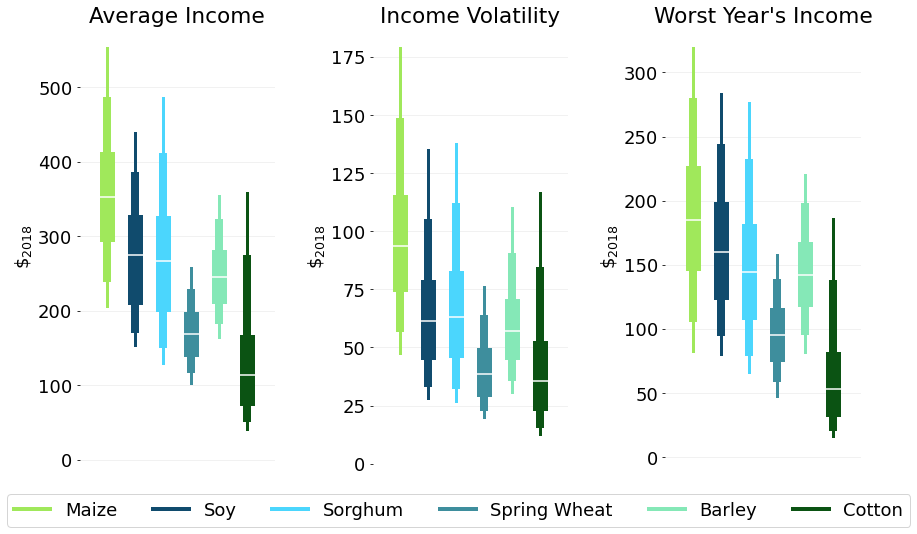

In [21]:
# 38071
res_q = pd.read_csv('../data/results/38071_NT_rdm_quantiles.csv')
res_q.rename(columns = {'Unnamed: 0':'quantile'}, inplace=True)
res_q.set_index(['crop', 'quantile'], inplace=True)

# So higher is better on parallel axis plot
# res_q['Income Volatility'] = 1./res_q['Income Volatility']

fig, axs = plt.subplots(1,3, figsize=(14,8))

crops = ['Maize', 'Soy', 'Sorghum', 'Spring Wheat', 'Barley', 'Cotton']
colors = ["#a0e85b", "#104b6d", "#4bd6fd", "#3e8e9d", "#85e8b7", "#0b5313"]
metrics = res_q.columns
titles = ['Average Income', 'Income Volatility', "Worst Year's Income"]

for i in range(3):
    for j in range(6):
        # Plot 1,5,25,50,75,95,99 quantiles
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.01][metrics[i]], res_q.loc[crops[j]].loc[0.99][metrics[i]]], lw=3, color=colors[j])
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.05][metrics[i]], res_q.loc[crops[j]].loc[0.95][metrics[i]]], lw=8, color=colors[j])
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.25][metrics[i]], res_q.loc[crops[j]].loc[0.75][metrics[i]]], lw=15, color=colors[j])
        axs[i].scatter(x=j, y=res_q.loc[crops[j]].loc[0.5][metrics[i]], s=300, color='white', marker='_', zorder=100)
        
    # Tidy
    axs[i].set_title(titles[i])
    axs[i].set_xticks([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].set_xlim([-1, 6])
    axs[i].set_ylabel('$\$_{2018}$')
    axs[i].grid(color='darkgray', alpha=0.2)
    if i == 1:
        axs[i].set_ylim(bottom=-0.001)
    else:
        axs[i].set_ylim(bottom=-5.)

plt.subplots_adjust(wspace=0.5)

# Legend
custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors]
axs[1].legend(custom_lines, crops, bbox_to_anchor=(2.8, -0.05), ncol=len(crops), fancybox=True)

plt.savefig('../figs/38071_RDM.pdf')

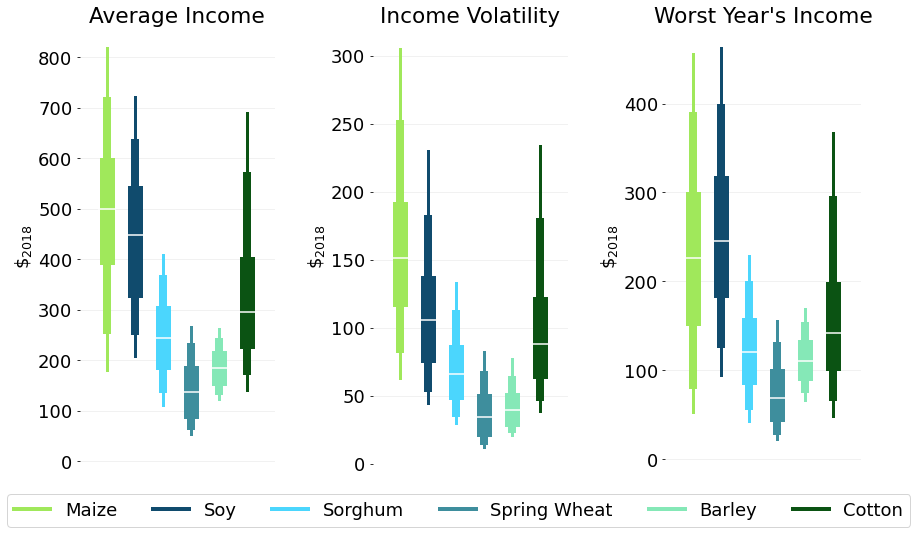

In [20]:
# 38071
res_q = pd.read_csv('../data/results/17019_NT_rdm_quantiles.csv')
res_q.rename(columns = {'Unnamed: 0':'quantile'}, inplace=True)
res_q.set_index(['crop', 'quantile'], inplace=True)

# So higher is better on parallel axis plot
# res_q['Income Volatility'] = 1./res_q['Income Volatility']

fig, axs = plt.subplots(1,3, figsize=(14,8))

crops = ['Maize', 'Soy', 'Sorghum', 'Spring Wheat', 'Barley', 'Cotton']
colors = ["#a0e85b", "#104b6d", "#4bd6fd", "#3e8e9d", "#85e8b7", "#0b5313"]
metrics = res_q.columns
titles = ['Average Income', 'Income Volatility', "Worst Year's Income"]

for i in range(3):
    for j in range(6):
        # Plot 1,5,25,50,75,95,99 quantiles
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.01][metrics[i]], res_q.loc[crops[j]].loc[0.99][metrics[i]]], lw=3, color=colors[j])
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.05][metrics[i]], res_q.loc[crops[j]].loc[0.95][metrics[i]]], lw=8, color=colors[j])
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.25][metrics[i]], res_q.loc[crops[j]].loc[0.75][metrics[i]]], lw=15, color=colors[j])
        axs[i].scatter(x=j, y=res_q.loc[crops[j]].loc[0.5][metrics[i]], s=300, color='white', marker='_', zorder=100)
        
    # Tidy
    axs[i].set_title(titles[i])
    axs[i].set_xticks([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].set_xlim([-1, 6])
    axs[i].set_ylabel('$\$_{2018}$')
    axs[i].grid(color='darkgray', alpha=0.2)
    if i == 1:
        axs[i].set_ylim(bottom=-0.001)
    else:
        axs[i].set_ylim(bottom=-5.)

plt.subplots_adjust(wspace=0.5)

# Legend
custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors]
axs[1].legend(custom_lines, crops, bbox_to_anchor=(2.8, -0.05), ncol=len(crops), fancybox=True)

plt.savefig('../figs/17019_RDM.pdf')

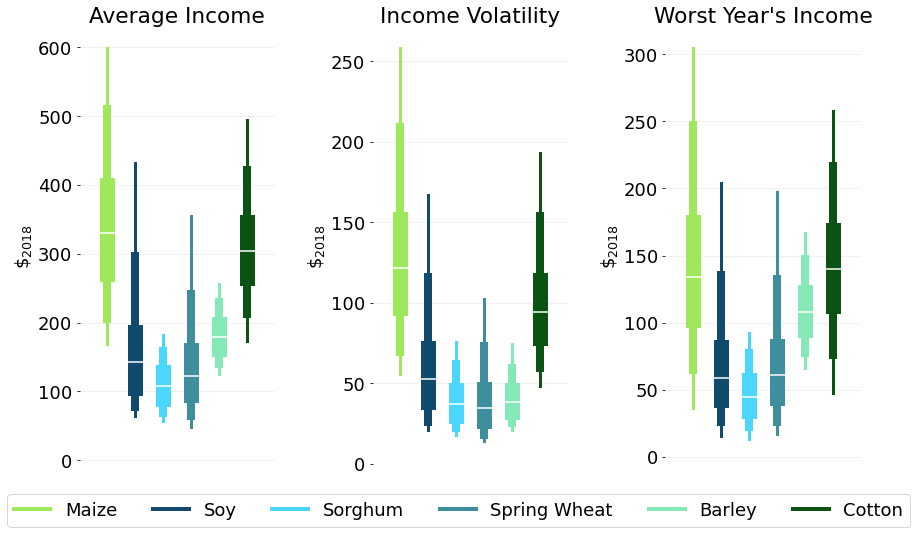

In [18]:
# 40039
res_q = pd.read_csv('../data/results/40039_NT_rdm_quantiles.csv')
res_q.rename(columns = {'Unnamed: 0':'quantile'}, inplace=True)
res_q.set_index(['crop', 'quantile'], inplace=True)

# So higher is better on parallel axis plot
# res_q['Income Volatility'] = 1./res_q['Income Volatility']

fig, axs = plt.subplots(1,3, figsize=(14,8))

crops = ['Maize', 'Soy', 'Sorghum', 'Spring Wheat', 'Barley', 'Cotton']
colors = ["#a0e85b", "#104b6d", "#4bd6fd", "#3e8e9d", "#85e8b7", "#0b5313"]
metrics = res_q.columns
titles = ['Average Income', 'Income Volatility', "Worst Year's Income"]

for i in range(3):
    for j in range(6):
        # Plot 1,5,25,50,75,95,99 quantiles
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.01][metrics[i]], res_q.loc[crops[j]].loc[0.99][metrics[i]]], lw=3, color=colors[j])
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.05][metrics[i]], res_q.loc[crops[j]].loc[0.95][metrics[i]]], lw=8, color=colors[j])
        axs[i].plot([j,j], [res_q.loc[crops[j]].loc[0.25][metrics[i]], res_q.loc[crops[j]].loc[0.75][metrics[i]]], lw=15, color=colors[j])
        axs[i].scatter(x=j, y=res_q.loc[crops[j]].loc[0.5][metrics[i]], s=300, color='white', marker='_', zorder=100)
        
    # Tidy
    axs[i].set_title(titles[i])
    axs[i].set_xticks([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].set_ylabel('$\$_{2018}$')
    axs[i].set_xlim([-1, 6])
    axs[i].grid(color='darkgray', alpha=0.2)
    if i == 1:
        axs[i].set_ylim(bottom=-0.001)
    else:
        axs[i].set_ylim(bottom=-5.)

plt.subplots_adjust(wspace=0.5)

# Legend
custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors]
axs[1].legend(custom_lines, crops, bbox_to_anchor=(2.8, -0.05), ncol=len(crops), fancybox=True)

plt.savefig('../figs/40039_RDM.pdf')